In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
def golden_section_search_with_log(f, a, b, tol=1e-5, max_iter=100):
    phi = (1 + np.sqrt(5)) / 2
    resphi = 2 - phi
    x1 = a + resphi*(b - a)
    x2 = b - resphi*(b - a)
    f1 = f(x1)
    f2 = f(x2)

    xs = []  # список для хранения x_k

    for _ in range(max_iter):
        # запишем текущее "лучшее" из двух
        xs.append(x1 if f1 < f2 else x2)
        if abs(b - a) < tol:
            break
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + resphi*(b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = b - resphi*(b - a)
            f2 = f(x2)

    best_x = x1 if f1 < f2 else x2
    xs.append(best_x)
    return best_x, f(best_x), xs

In [3]:
def parabolic_search_with_log(f, a, b, tol=1e-5, max_iter=100):
    x1, x3 = a, b
    x2 = 0.5*(a + b)
    f1, f2, f3 = f(x1), f(x2), f(x3)

    xs = []
    for _ in range(max_iter):
        best_x = min((x1, x2, x3), key=lambda xx: f(xx))
        xs.append(best_x)
        if abs(x3 - x1) < tol:
            break

        # Параболическая вершина
        num = (x2 - x1)**2 * (f2 - f3) - (x2 - x3)**2 * (f2 - f1)
        den = 2 * ((x2 - x1)*(f2 - f3) - (x2 - x3)*(f2 - f1))
        if abs(den) < 1e-15:
            u = 0.5*(x1 + x3)
        else:
            u = x2 - num/den
        fu = f(u)

        # Сужаем интервал
        if u < x2:
            if fu < f2:
                x3, f3 = x2, f2
                x2, f2 = u, fu
            else:
                x1, f1 = u, fu
        else:
            if fu < f2:
                x1, f1 = x2, f2
                x2, f2 = u, fu
            else:
                x3, f3 = u, fu

    best_x = min((x1, x2, x3), key=lambda xx: f(xx))
    xs.append(best_x)
    return best_x, f(best_x), xs

In [4]:
def parabolic_solve_with_log(f, a, b, tol=1e-5, max_iter=100):
    import numpy as np
    x1, x3 = a, b
    x2 = 0.5*(a + b)
    f1, f2, f3 = f(x1), f(x2), f(x3)

    xs = []
    for _ in range(max_iter):
        best_x = min((x1,x2,x3), key=lambda xx: f(xx))
        xs.append(best_x)

        if abs(x3 - x1) < tol:
            break

        A = np.array([[x1**2, x1, 1],
                      [x2**2, x2, 1],
                      [x3**2, x3, 1]], dtype=float)
        Fv = np.array([f1, f2, f3], dtype=float)

        try:
            a_, b_, c_ = np.linalg.solve(A, Fv)
        except np.linalg.LinAlgError:
            u = 0.5*(x1 + x3)
        else:
            if abs(a_) < 1e-15:
                u = 0.5*(x1 + x3)
            else:
                u = -b_/(2*a_)

        fu = f(u)
        if u < x2:
            if fu < f2:
                x3, f3 = x2, f2
                x2, f2 = u, fu
            else:
                x1, f1 = u, fu
        else:
            if fu < f2:
                x1, f1 = x2, f2
                x2, f2 = u, fu
            else:
                x3, f3 = u, fu

    best_x = min((x1,x2,x3), key=lambda xx: f(xx))
    xs.append(best_x)
    return best_x, f(best_x), xs

In [5]:
def brent_method_with_log(f, a, b, tol=1e-5, max_iter=100):
    R = 0.5*(3.0 - np.sqrt(5.0))
    x = w = v = 0.5*(a+b)
    fx = fw = fv = f(x)
    d = e = b - a

    xs = []

    for _ in range(max_iter):
        xs.append(x)
        m = 0.5*(a+b)
        tol1 = np.sqrt(1e-16)*abs(x) + tol/3
        if abs(x - m) <= (2*tol1 - 0.5*(b-a)):
            break
        p = q = 0.0
        r = 0.0
        xm = x - w
        xn = x - v
        fw_diff = fw - fx
        fv_diff = fv - fx
        if (abs(xm)>tol1 and abs(xn)>tol1 and
            abs(fw_diff)>1e-15 and abs(fv_diff)>1e-15):
            p = xm*xm*fv_diff - xn*xn*fw_diff
            q = 2.0*(xm*fv_diff - xn*fw_diff)
            if q>0: p = -p
            q = abs(q)
            r = e
            e = d
            if (abs(p) < abs(0.5*q*r)) and (p > q*(a-x)) and (p < q*(b-x)):
                d = p/q
            else:
                e = (b-a)
                d = R*e if (x<m) else -R*e
        else:
            e = (b-a)
            d = R*e if (x<m) else -R*e

        if abs(d) < tol1:
            d = np.copysign(tol1, d)

        u = x + d
        fu = f(u)
        if fu <= fx:
            if u < x: b = x
            else:     a = x
            v, fv = w, fw
            w, fw = x, fx
            x, fx = u, fu
        else:
            if u < x: a = u
            else:     b = u
            if fu <= fw or w==x:
                v, fv = w, fw
                w, fw = u, fu
            elif fu <= fv or v==x or v==w:
                v, fv = u, fu

    xs.append(x)
    return x, fx, xs

In [6]:
def scipy_minimize_scalar_with_log(func, a, b, method='brent', tol=1e-5, max_iter=100):
    xs = []

    def wrapped_f(x):
        xs.append(x)
        return func(x)

    options = {
        'maxiter': max_iter,
        'xatol': tol
    }

    if method == 'bounded':
        res = minimize_scalar(wrapped_f, bounds=(a, b), method='bounded', options=options)
    else:
        res = minimize_scalar(wrapped_f, bracket=(a, b), method=method, options=options)

    return res.x, res.fun, xs

def restricted_func(x, a, b, original_func):
    if x < a:
        return 1e15 + (a - x)**2
    elif x > b:
        return 1e15 + (x - b)**2
    else:
        return original_func(x)

In [ ]:
test_functions = [
    (
        lambda x: -5*x**5 + 4*x**4 - 12*x**3 + 11*x**2 - 2*x + 1,
        -0.5, 0.5, "f1(x) = -5x^5 + 4x^4 - 12x^3 + 11x^2 - 2x + 1"
    ),
    (
        lambda x: -(np.log(x - 2))**2 + (np.log(10 - x))**2 - x**0.2,
        6.0, 9.9,  "f2(x) = -ln^2(x - 2) + ln^2(10 - x) - x^0.2"
    ),
    (
        lambda x: -3*x*np.sin(0.75*x) + np.exp(-2*x),
        0.0, 2*np.pi, "f3(x) = -3x sin(0.75x) + e^-2x"
    ),
    (
        lambda x: np.exp(3*x) + 5*np.exp(-2*x),
        0.0, 1.0,  "f4(x) = e^(3x) + 5e^(-2x)"
    ),
    (
        lambda x: 0.2*x*np.log(x) + (x - 2.3)**2,
        0.5, 2.5,  "f5(x) = 0.2 x ln(x) + (x - 2.3)^2"
    )
]

multimodal_functions = [
    (
        lambda x: (x**2 - 3)**2 + np.sin(5*x),
        -2, 3, "f1(x) = (x^2 - 3)^2 + sin(5x)"),
    (
        lambda x: 0.1*(x**2) + np.cos(3*x) + 2*np.sin(5*x),
                -2, 2, "f2(x) = 0.1 x^2 + cos(3x) + 2 sin(5x)")
]


def task_1_3():
    for idx, (func, A, B, label_name) in enumerate(test_functions, start=1):
        res = minimize_scalar(func, bounds=(A, B), method='bounded')
        x_star = res.x
        f_star = res.fun

        xg, fg, log_g = golden_section_search_with_log(func, A, B, tol=1e-7, max_iter=300)
        xp, fp, log_p = parabolic_search_with_log(func, A, B, tol=1e-7, max_iter=300)
        xs_, fs_, log_s = parabolic_solve_with_log(func, A, B, tol=1e-7, max_iter=300)
        xb, fb, log_b = brent_method_with_log(func, A, B, tol=1e-7, max_iter=300)

        err_g = [abs(xk - x_star) for xk in log_g]
        err_p = [abs(xk - x_star) for xk in log_p]
        err_s = [abs(xk - x_star) for xk in log_s]
        err_b = [abs(xk - x_star) for xk in log_b]

        print(f"=== {label_name}  [{A}, {B}] ===")
        print(f"   SciPy (bounded) -> x*={x_star:.8f}, f*={f_star:.8f}")
        print(f"   Golden Section  -> x={xg:.8f}, f={fg:.8f}, iters={len(log_g)}")
        print(f"   Parabolic       -> x={xp:.8f}, f={fp:.8f}, iters={len(log_p)}")
        print(f"   ParabolicSolve  -> x={xs_:.8f}, f={fs_:.8f}, iters={len(log_s)}")
        print(f"   Brent           -> x={xb:.8f}, f={fb:.8f}, iters={len(log_b)}")
        print()

        plt.figure(figsize=(6, 4))
        # plt.title(f"{label_name}\nInterval = [{A}, {B}]")

        plt.semilogy(err_g, label="Золотое сечение")
        plt.semilogy(err_p, label="Парабола явная")
        plt.semilogy(err_s, label="Парабола солвер")
        plt.semilogy(err_b, label="Брент")

        plt.xlabel("Номер итерации")
        plt.ylabel("Логарифмическая ошибка")
        plt.legend()
        plt.grid(True)

        # plt.savefig(f"images/task1/f{idx}.png")
        plt.show()


def task_1_4():
    for idx, (func, A, B, label_name) in enumerate(test_functions, start=1):
        res_etalon = minimize_scalar(func, bounds=(A, B), method='bounded')
        x_star = res_etalon.x
        f_star = res_etalon.fun

        xg, fg, log_g = golden_section_search_with_log(func, A, B, tol=1e-7, max_iter=300)
        xp, fp, log_p = parabolic_search_with_log(func, A, B, tol=1e-7, max_iter=300)
        xs_, fs_, log_s = parabolic_solve_with_log(func, A, B, tol=1e-7, max_iter=300)
        xb, fb, log_b = brent_method_with_log(func, A, B, tol=1e-7, max_iter=300)

        x_sbrent, f_sbrent, log_sbrent = scipy_minimize_scalar_with_log(lambda x: restricted_func(x, A, B, func), A, B, method='brent',   tol=1e-7, max_iter=300)
        x_sgold,  f_sgold,  log_sgold = scipy_minimize_scalar_with_log(lambda x: restricted_func(x, A, B, func), A, B, method='golden',  tol=1e-7, max_iter=300)
        x_sbound, f_sbound, log_sbound = scipy_minimize_scalar_with_log(func, A, B, method='bounded', tol=1e-7, max_iter=300)

        err_g = [abs(xk - x_star) for xk in log_g]
        err_p = [abs(xk - x_star) for xk in log_p]
        err_s = [abs(xk - x_star) for xk in log_s]
        err_b = [abs(xk - x_star) for xk in log_b]

        err_sbrent =  [abs(xk - x_star) for xk in log_sbrent]
        err_sgold  =  [abs(xk - x_star) for xk in log_sgold]
        err_sbound =  [abs(xk - x_star) for xk in log_sbound]

        print(f"=== {label_name}  [{A}, {B}] ===")
        print(f"  Эталон (bounded) : x*={x_star:.8f}, f(x*)={f_star:.8f}")
        print(f"  Наш Golden       : x={xg:.8f}, f={fg:.8f},   iters={len(log_g)}")
        print(f"  Наш Parabolic    : x={xp:.8f}, f={fp:.8f},   iters={len(log_p)}")
        print(f"  Наш Parab.Solve  : x={xs_:.8f}, f={fs_:.8f}, iters={len(log_s)}")
        print(f"  Наш Brent        : x={xb:.8f}, f={fb:.8f},   iters={len(log_b)}")
        print(f"  SciPy Brent      : x={x_sbrent:.8f}, f={f_sbrent:.8f},   calls={len(log_sbrent)}")
        print(f"  SciPy Golden     : x={x_sgold:.8f},  f={f_sgold:.8f},    calls={len(log_sgold)}")
        print(f"  SciPy Bounded    : x={x_sbound:.8f}, f={f_sbound:.8f},   calls={len(log_sbound)}")
        print()

        plt.figure(figsize=(7,5))
        # plt.title(f"{label_name}\nInterval = [{A}, {B}]")

        plt.semilogy(err_g, label="Золотое сечение")
        plt.semilogy(err_p, label="Парабола явная")
        plt.semilogy(err_s, label="Парабола солвер")
        plt.semilogy(err_b, label="Брент")
        plt.semilogy(err_sgold,  label="SciPy Золотое сечение")
        plt.semilogy(err_sbound, label="SciPy Парабола")
        plt.semilogy(err_sbrent, label="SciPy Брент")

        plt.xlabel("Номер итерации")
        plt.ylabel("Логарифмическая ошибка")
        plt.legend()
        plt.grid(True)

        # plt.savefig(f"images/task1/f{idx}_with_scipy.png")
        plt.show()


def task_1_5():
    methods = [
        ("Золотое сечение", golden_section_search_with_log, 'blue'),
        ("Парабола (явная)", parabolic_search_with_log, 'orange'),
        ("Парабола (solve)", parabolic_solve_with_log, 'green'),
        ("Брент", brent_method_with_log, 'red')
    ]
    for idx, (func, a, b, label) in enumerate(multimodal_functions, start=1):
        xs = np.linspace(a-1, b+1, 400)
        ys = [func(x) for x in xs]

        plt.figure(figsize=(7,4))
        plt.plot(xs, ys, 'k-', label='f(x)')
        plt.axvline(a, color='gray', linestyle='--', alpha=0.7)
        plt.axvline(b, color='gray', linestyle='--', alpha=0.7)

        for (method_name, method_func, color) in methods:
            best_x, best_val, log_xs = method_func(func, a, b, tol=1e-5, max_iter=200)

            if len(log_xs) > 0:
                iter_points_x = log_xs
                iter_points_y = [func(xx) for xx in iter_points_x]

                plt.plot(iter_points_x, iter_points_y, marker='o', color=color, linestyle='--',
                         label=f"{method_name}: путь")

                init_x = iter_points_x[0]
                init_y = iter_points_y[0]
                plt.plot(init_x, init_y, 's', color=color,
                         label=f"{method_name}: начало={init_x:.2f}")

                plt.plot(best_x, best_val, 'D', color=color,
                         label=f"{method_name}: результат={best_x:.2f}")

        # plt.title(f"{label} на [{a}, {b}]")
        plt.xlim([a-0.5, b+0.5])
        plt.ylim([-5, 10])
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)

        plt.savefig(f"images/task1/multifunc_{idx}.png", bbox_inches='tight')
        plt.show()

task_1_3()
task_1_4()
task_1_5()

constant


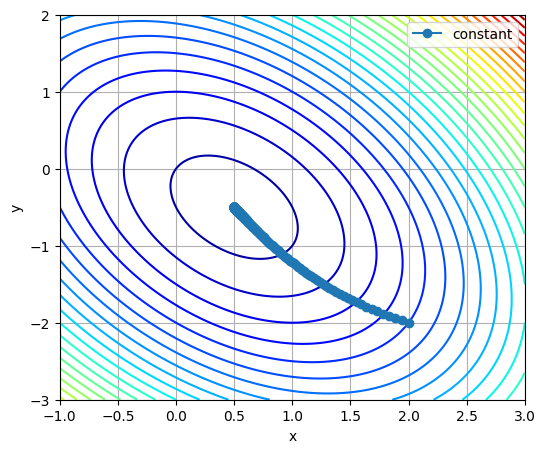

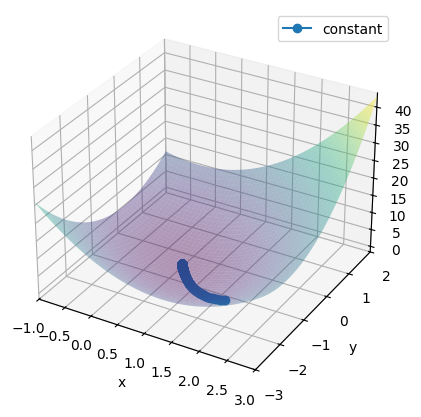

line_search


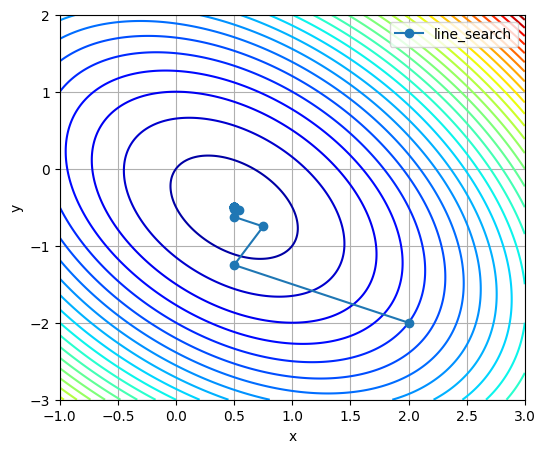

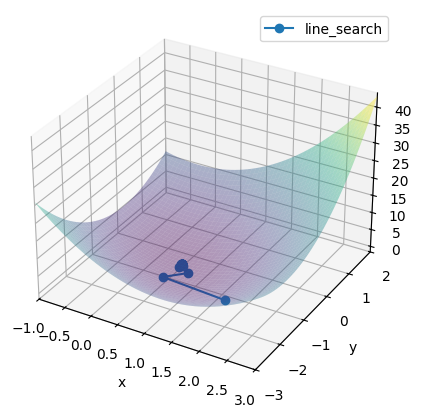

lipschitz


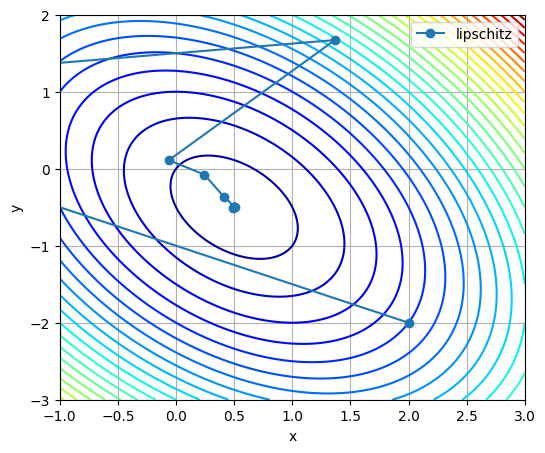

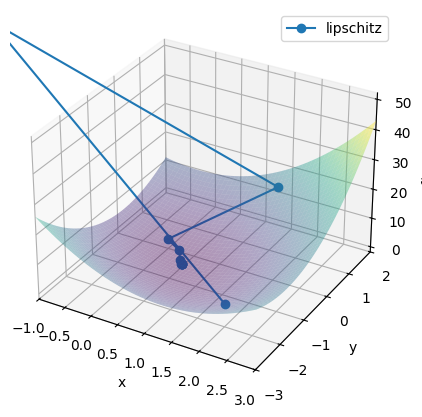

backtracking


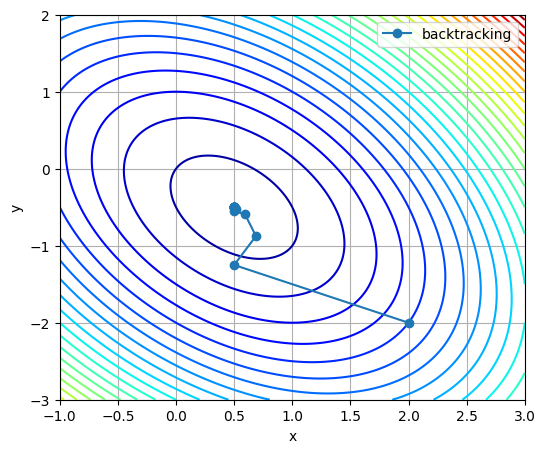

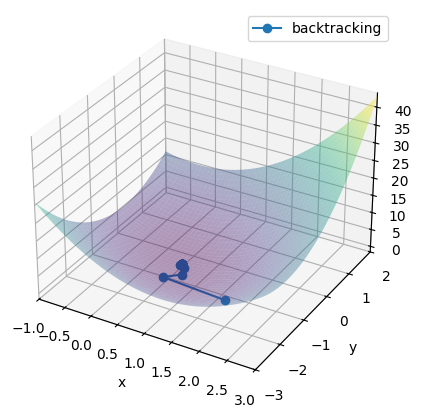

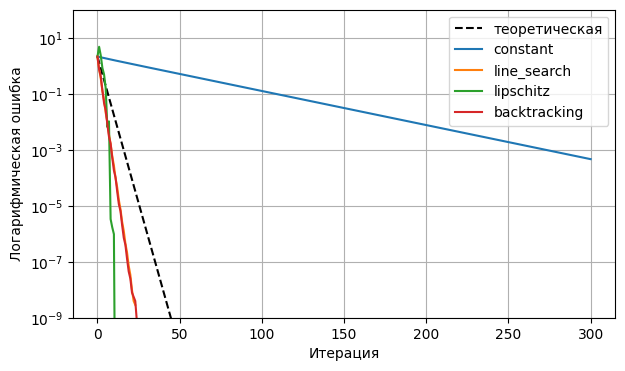

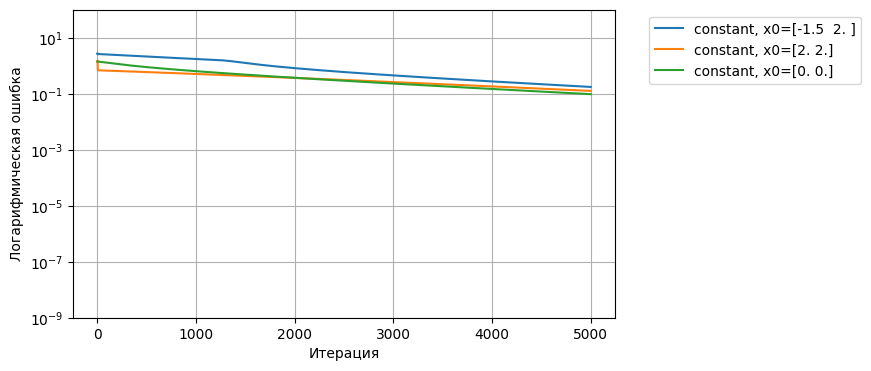

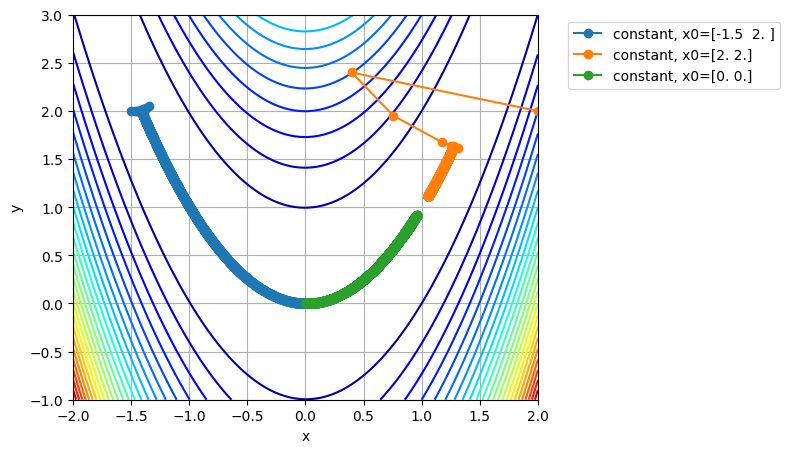

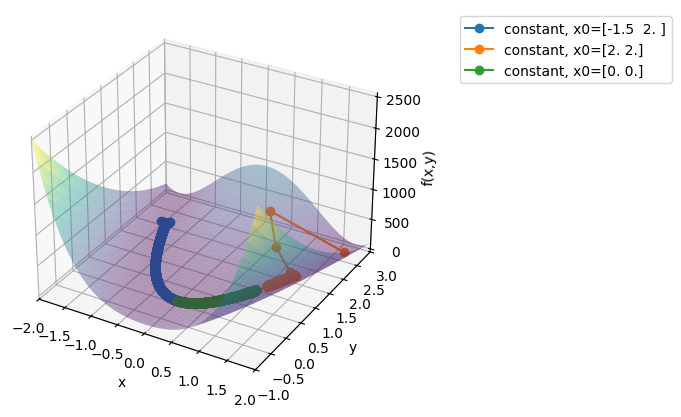

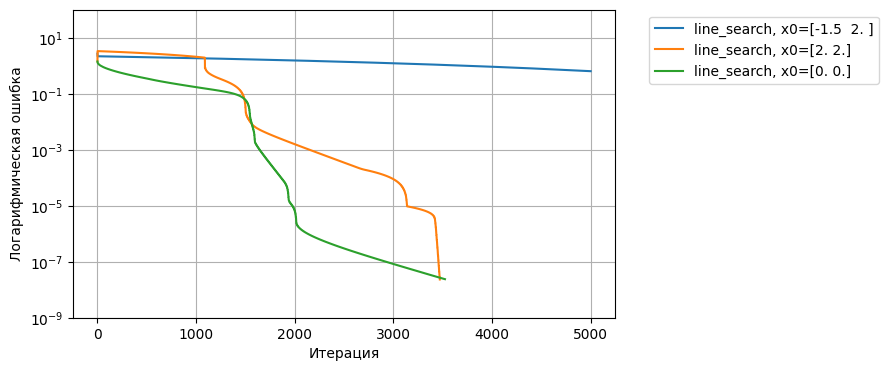

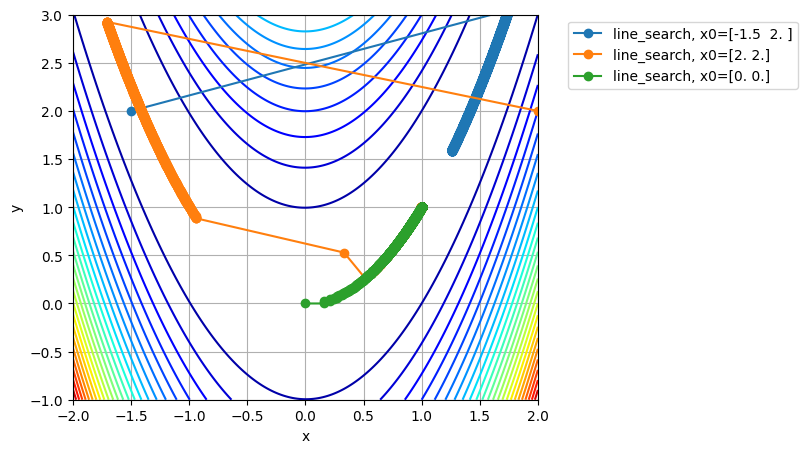

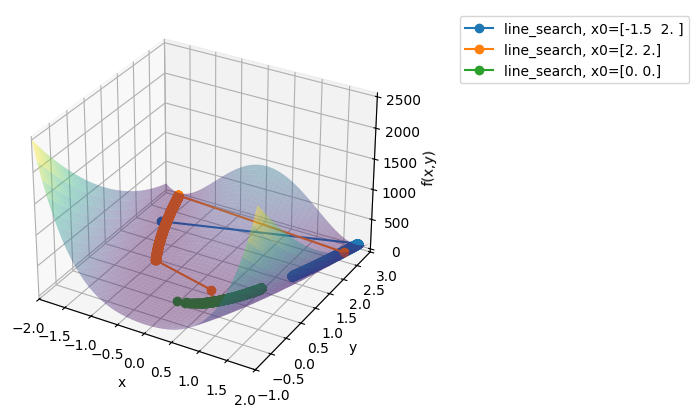

/tmp/ipykernel_7704/2840948369.py:204: RuntimeWarning: overflow encountered in scalar power
  return (1 - x)**2 + 100*(y - x**2)**2
/tmp/ipykernel_7704/2840948369.py:208: RuntimeWarning: overflow encountered in scalar power
  dfdx = -2*(1 - x) - 400*x*(y - x**2)
/tmp/ipykernel_7704/2840948369.py:209: RuntimeWarning: overflow encountered in scalar power
  dfdy = 200*(y - x**2)
/tmp/ipykernel_7704/2840948369.py:36: RuntimeWarning: invalid value encountered in scalar divide
  return num/den


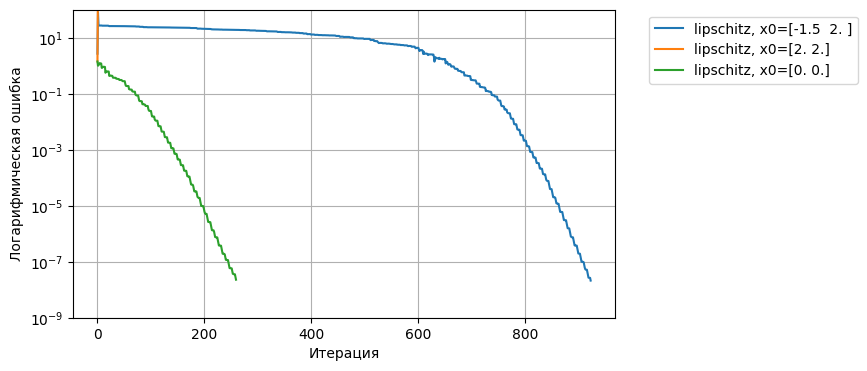

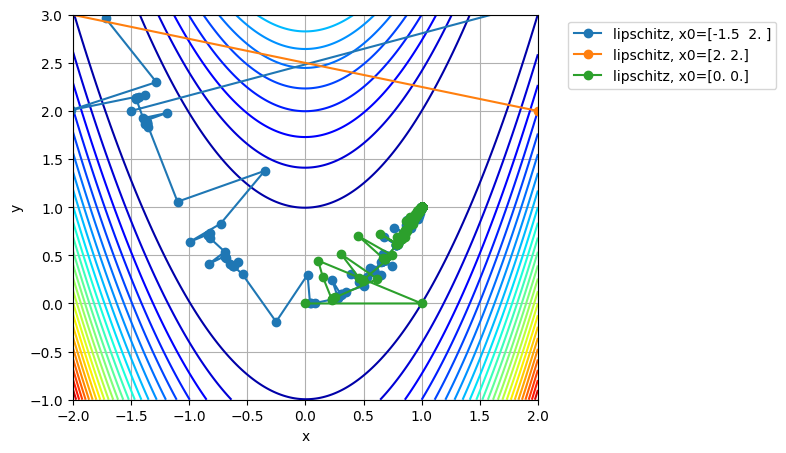

/home/dinislam/study/.venv/lib/python3.12/site-packages/mpl_toolkits/mplot3d/proj3d.py:150: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0] / w, vecw[1] / w, vecw[2] / w


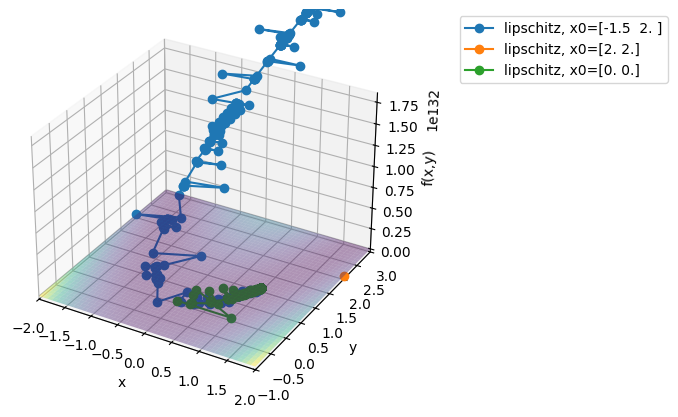

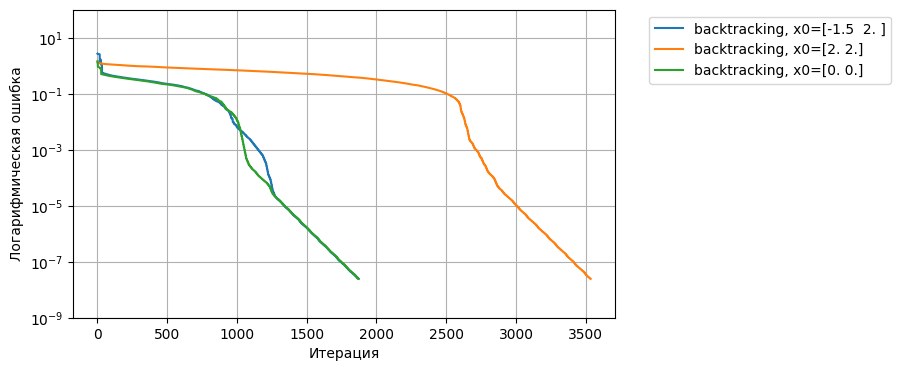

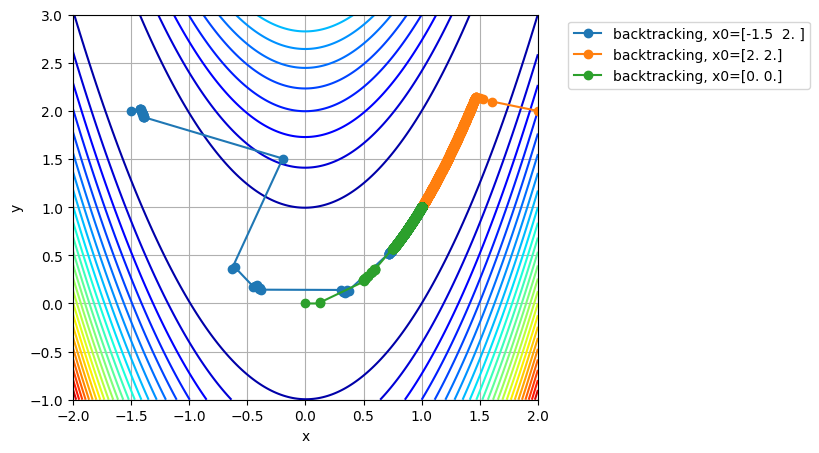

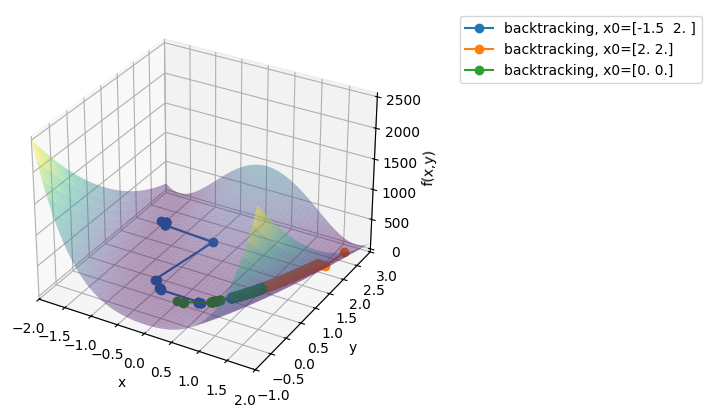

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def line_search_1d(xk, grad_fk, f, alpha_max=10.0, tol=1e-5):
    def phi(alpha):
        # g(alpha) = f(xk - alpha * grad_fk)
        return f(xk - alpha*grad_fk)

    # вызываем наш одномерный метод (Brent, Золотое сечение и т.д.)
    alpha_star, _, _ = brent_method_with_log(phi, 0, alpha_max, tol=tol, max_iter=100)
    return alpha_star

def backtracking_armijo(xk, grad_fk, f, alpha0=1.0, c=0.5, rho=0.5):
    alpha = alpha0
    fk = f(xk)
    grad_norm_sq = np.dot(grad_fk, grad_fk)

    while True:
        new_x = xk - alpha*grad_fk
        if f(new_x) <= fk - c*alpha*grad_norm_sq:
            break
        alpha *= rho
        if alpha < 1e-12:
            break

    return alpha

def lipschitz_estimate(xk, x_prev, grad_fk, grad_f_prev):
    if x_prev is None or grad_f_prev is None:
        return 1.0
    diff_grad = grad_fk - grad_f_prev
    diff_x = xk - x_prev
    num = np.linalg.norm(diff_grad)
    den = np.linalg.norm(diff_x)
    if den < 1e-15:
        return 1.0
    return num/den

def gradient_descent(f, grad_f, x0, strategy="constant",
                     alpha_const=1e-2, alpha_max=10.0,  alpha0_bt=1.0, c_bt=0.5, rho_bt=0.5,
                     alpha_upper=1.0, alpha_lower=1e-6, tol=1e-6, max_iter=1000):
    xk = np.array(x0, dtype=float)
    fk = f(xk)
    grad_fk = grad_f(xk)
    grad_norm = np.linalg.norm(grad_fk)

    history = [(xk.copy(), fk, grad_norm)]

    x_prev = None
    grad_f_prev = None
    Lk = 1.0

    for k in range(max_iter):
        if grad_norm < tol:
            break

        # Выбираем alpha_k в зависимости от strategy
        if strategy == "constant":
            alpha_k = alpha_const

        elif strategy == "line_search":
            alpha_k = line_search_1d(xk, grad_fk, f, alpha_max=alpha_max)

        elif strategy == "lipschitz":
            Lk = lipschitz_estimate(xk, x_prev, grad_fk, grad_f_prev)
            alpha_k = 1.0 / Lk

        elif strategy == "backtracking":
            alpha_k = backtracking_armijo(xk, grad_fk, f,
                                          alpha0=alpha0_bt, c=c_bt, rho=rho_bt)
        else:
            raise ValueError(f"Неизвестная стратегия шага: {strategy}")

        if alpha_k > alpha_upper:
            alpha_k = alpha_upper
        if alpha_k < alpha_lower:
            alpha_k = alpha_lower

        x_next = xk - alpha_k * grad_fk

        x_prev = xk
        grad_f_prev = grad_fk

        xk = x_next
        fk = f(xk)
        grad_fk = grad_f(xk)
        grad_norm = np.linalg.norm(grad_fk)

        history.append((xk.copy(), fk, grad_norm))
    return xk, history

def plot_convergence(strategies_results, x_star_theory, f_star_theory, x0=None, mu=None, L=None, legend_p=None, title=''):
    plt.figure(figsize=(7,4))

    if x0 is not None and mu is not None and L is not None:
        q = (1.0 - mu/L)
        if 1.0 > q > 0.0:
            err0 = np.linalg.norm(x0 - x_star_theory)
            k_range = np.arange(0, 301)
            err_theor = err0*(q**k_range)
            plt.semilogy(k_range, err_theor, 'k--', label='теоретическая')

    for strat, (x_end, hist) in strategies_results.items():
        err_x = []
        for (xk, fk, gnorm) in hist:
            err_x.append(np.linalg.norm(xk - x_star_theory))
        plt.semilogy(err_x, label=strat)

    # plt.title("Ошибка по x")
    plt.xlabel("Итерация")
    plt.ylabel("Логарифмическая ошибка")
    if legend_p is not None:
        plt.legend(**legend_p)
    else:
        plt.legend()
    plt.grid(True)
    plt.ylim([1e-9, 1e2])

    # plt.tight_layout()
    plt.savefig(f"images/task2/convergence_x_error{title}.png", bbox_inches='tight')
    plt.show()


def plot_levels_2d(f, strategies_results, xlim=(-2,3), ylim=(-3,2), n_points=200, legend_p=None, title=''):
    xs = np.linspace(xlim[0], xlim[1], n_points)
    ys = np.linspace(ylim[0], ylim[1], n_points)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    for i in range(n_points):
        for j in range(n_points):
            point = np.array([X[i,j], Y[i,j]])
            Z[i,j] = f(point)

    plt.figure(figsize=(6,5))
    # Линии уровня
    plt.contour(X, Y, Z, levels=30, cmap='jet')

    # Траектории
    for strat, (x_end, hist) in strategies_results.items():
        pts = np.array([h[0] for h in hist])  # extract xk
        plt.plot(pts[:,0], pts[:,1], '-o', label=strat)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.title("Линии уровня + траектории GD")
    if legend_p is not None:
        plt.legend(**legend_p)
    else:
        plt.legend()
    plt.grid(True)
    plt.savefig(f"images/{title}.png", bbox_inches='tight')
    plt.show()


def plot_3d_surface_and_paths(f, strategies_results, xlim=(-2,3), ylim=(-3,2), n_points=50, legend_p=None, title=None):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')

    xs = np.linspace(xlim[0], xlim[1], n_points)
    ys = np.linspace(ylim[0], ylim[1], n_points)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    for i in range(n_points):
        for j in range(n_points):
            point = np.array([X[i,j], Y[i,j]])
            Z[i,j] = f(point)

    # Рисуем поверхность
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4)

    # Траектории
    for strat, (x_end, hist) in strategies_results.items():
        pts = np.array([h[0] for h in hist])  # (xk,y k)
        xyz = []
        for xk in pts:
            xyz.append([xk[0], xk[1], f(xk)])
        xyz = np.array(xyz)
        ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], '-o', label=strat)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # zlim можно автоматически
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    # ax.set_title("3D-поверхность + траектории GD")
    if legend_p is not None:
        ax.legend(**legend_p)
    else:
        ax.legend()
    plt.savefig(f"images/{title}.png", bbox_inches='tight')
    plt.show()


def f_quad(x, A, b):
    return x.T @ A @ x + b.T @ x

def grad_f_quad(x, A, b):
    return 2*A@x + b

def rosenbrock_f(xy):
    x, y = xy
    return (1 - x)**2 + 100*(y - x**2)**2

def rosenbrock_grad(xy):
    x, y = xy
    dfdx = -2*(1 - x) - 400*x*(y - x**2)
    dfdy = 200*(y - x**2)
    return np.array([dfdx, dfdy])


def run_all_strategies(A, b, x0):
    def f(x): return f_quad(x, A, b)
    def grad_f(x): return grad_f_quad(x, A, b)

    strategies = ["constant", "line_search", "lipschitz", "backtracking"]
    results = {}
    for strat in strategies:
        print(strat)
        x_star, hist = gradient_descent(f, grad_f, x0, strategy=strat,
                                        alpha_const=1e-2,  # для constant
                                        alpha_max=5.0,     # для line_search
                                        alpha0_bt=1.0, c_bt=0.5, rho_bt=0.5,
                                        tol=1e-8, max_iter=300)
        res = {strat: (x_star, hist)}
        results[strat] = res[strat]

        plot_levels_2d(f, res, xlim=(-1,3), ylim=(-3,2), title=f"task2/plot_levels_2_2_{strat}")
        plot_3d_surface_and_paths(f, res, xlim=(-1,3), ylim=(-3,2), title=f"task2/plot_3d_2_2_{strat}")
    return results


def task_2_2():
    A = np.array([[3.0, 1.0],
                  [1.0, 2.0]])
    b = np.array([-2.0, 1.0])

    A_inv = np.linalg.inv(A)
    x_star_theory = -0.5*(A_inv @ b)
    f_star_theory = f_quad(x_star_theory, A, b)

    w, _ = np.linalg.eig(A)
    lambda_min = min(w)
    lambda_max = max(w)
    mu = 2*lambda_min
    L = 2*lambda_max

    x0 = np.array([2.0, -2.0])

    results = run_all_strategies(A, b, x0)

    plot_convergence(results, x_star_theory, f_star_theory, x0, mu, L, title='_all_strategies')


def main_rosenbrock_demo():
    # Глобальный минимум: (1,1), f(1,1)=0
    x_star_theory = np.array([1.0, 1.0])
    f_star_theory = 0.0

    # Несколько начальных точек
    x0_list = [
        np.array([-1.5, 2.0]),
        np.array([2.0, 2.0]),
        np.array([0.0, 0.0])
    ]
    # Несколько стратегий
    strategies = ["constant", "line_search", "lipschitz", "backtracking"]

    # Запустим всё и соберём в один словарь results
    results_dict = {}
    for s in strategies:
        mid_results = {}
        for i, x0 in enumerate(x0_list):
            label = f"{s}, x0={x0}"
            x_end, hist = gradient_descent(
                rosenbrock_f, rosenbrock_grad, x0,
                strategy=s,
                alpha_const=1e-3,  # для constant
                alpha_max=1.0,     # для line_search
                alpha0_bt=1.0, c_bt=0.5, rho_bt=0.5,
                tol=1e-8, max_iter=5000,
                alpha_upper=0.5, alpha_lower=1e-8,
            )
            mid_results[label] = (x_end, hist)
        results_dict.update(mid_results)
        plot_convergence(mid_results, x_star_theory, f_star_theory, legend_p={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'}, title=f"_2_3_{s}")
        plot_levels_2d(rosenbrock_f, mid_results, xlim=(-2,2), ylim=(-1,3), legend_p={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'}, title=f"task2/plot_levels_2_3_{s}")
        plot_3d_surface_and_paths(rosenbrock_f, mid_results, xlim=(-2,2), ylim=(-1,3), legend_p={'bbox_to_anchor': (1.15, 1), 'loc': 'upper left'}, title=f"task2/plot_3d_2_3_{s}")


task_2_2()
main_rosenbrock_demo()

[6.0163771  4.01091607]
86


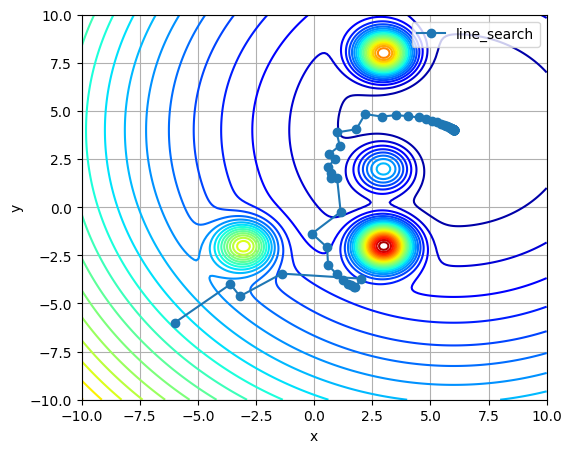

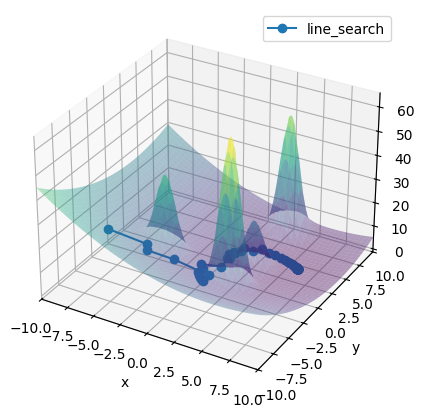

In [9]:
def potentional_function(xy):
    x,y = xy
    a = 0.1
    simga_x = 0.8
    sigma_y = 0.8
    b_i = np.array([20,30,50,60])
    x_b,y_b = target_point = np.array([6,4])
    obstacles_peaks = np.array([[3,2],[-3,-2],[3,8],[3,-2]])
    return a*((x-x_b)**2 +(y-y_b)**2) + sum([b_i[i]*np.exp(-((x-obstacles_peaks[i,0])**2)/(2*simga_x**2) -((y-obstacles_peaks[i,1])**2)/(2*sigma_y**2)) for i in range(len(obstacles_peaks))])

def potentional_function_grad(xy):
    step=1e-8
    x,y = xy
    df_dx = (potentional_function((x + step, y)) - potentional_function((x - step, y))) / (2 * step)
    df_dy = (potentional_function((x, y + step)) - potentional_function((x, y - step))) / (2 * step)
    return np.array([df_dx, df_dy])

def task3():
    descent_result = gradient_descent(potentional_function,potentional_function_grad,[-6,-6],strategy='line_search')
    print(descent_result[0])
    print(len(descent_result[1]))
    plot_levels_2d(potentional_function,{'line_search':(descent_result[0],descent_result[1])}, [-10,10],[-10,10], 200, title="task3/plot_levels_3_potential")
    plot_3d_surface_and_paths(potentional_function,{'line_search':(descent_result[0],descent_result[1])}, [-10,10],[-10,10], 200, title="task3/plot_3d_3_potential")
task3()